In [121]:
from scipy.io import loadmat
from scipy.sparse import issparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from Data import VFLDataset
from torch.utils.data import DataLoader
import VFL
import torch
import os
DIR = "Data"

In [122]:
file_name = 'arcene.mat'
mat = loadmat(os.path.join(DIR, file_name))
X = mat["X"]
y = mat["Y"]
if issparse(X):
    X = X.todense()
y = y.flatten()
print(file_name, X.shape, y.shape)
y[np.where(y == -1)] = 0
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
dataset = VFLDataset(data_source=(X, y), 
                    num_clients=2,
                    gini_portion=None,
                    insert_noise=False,
                    test_size=0.5)
train_loader = DataLoader(dataset.train(), batch_size=128, shuffle=True)
val_loader = DataLoader(dataset.valid(), batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset.test(), batch_size=1000, shuffle=True)
input_dim_list = dataset.get_input_dim_list()
output_dim = np.unique(y).size
criterion = torch.nn.CrossEntropyLoss()

arcene.mat (200, 10000) (200,)
Client 0: Feature Index 0-3333
Client 1: Feature Index 3334-6666
Server : Feature Index 6667-9999


In [123]:
models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=8,
                            output_dim=output_dim, hidden_dims=[8, 8],
                            activation='relu', lam=0.2)

In [124]:
gini_labels = dataset.gini_filter(0.5)
feat_idx_list = dataset.get_feature_index_list()
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
gini_models, gini_top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=8,
                            output_dim=output_dim, hidden_dims=[8, 8],
                            activation='relu', lam=0.2, mus=mus)

In [125]:
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
dual_models, dual_top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='DualSTG',
                            emb_dim=8,
                            output_dim=output_dim, hidden_dims=[8, 8],
                            activation='relu', lam=0.2, mus=mus, top_lam=0.1)


The strategy is:
Train STG: GET the number of remaining features
Set the threshold as the number of features => Run SFFS
Train STG with GINI Initialization: 

In [126]:
results = []

In [127]:
for i, step in enumerate([10]*20):
    history = VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=step, noise_label=None, criterion=criterion, 
                verbose=False, save_mask_at=100000)
    
    num_feats = history.tail(1)['num_feats'].item()
    acc = history.tail(1)['test_acc'].item()
    print(f'STG:{num_feats}')
    print(f'STG Acc:{acc}')
    gini_history = VFL.train(
        gini_models, gini_top_model, train_loader, val_loader, test_loader,
        epochs=step, noise_label=None, criterion=criterion,
        verbose=False, save_mask_at=100000)
    gini_num_feats = gini_history.tail(1)['num_feats'].item()
    gini_acc = gini_history.tail(1)['test_acc'].item()
    print(f'GINI+STG: {gini_num_feats}')
    print(f'GINI+STG Acc: {gini_acc}')
    dual_history = VFL.train(
        dual_models, dual_top_model, train_loader, val_loader, test_loader,
        epochs=step, noise_label=None, criterion=criterion,
        verbose=False, save_mask_at=100000, freeze_top_till=0)
    saved_communication = dual_history['num_emb'].sum()
    pred_emb = dual_history.tail(1)['num_emb'].item()
    dual_acc = dual_history.tail(1)['test_acc'].item()
    dual_num_feats = dual_history.tail(1)['num_feats'].item()
    print(f'DualSTG: {dual_acc}')
    print(f'DualSTG: {saved_communication}')
    print(f'DualSTG: {dual_num_feats}')
    print("What's the Test accuracy if SFFS only have this much features?")
    percentage = num_feats/X.shape[1]
    sffs_labels = dataset.gini_filter(percentage)
    sffs_labels = sffs_labels.flatten()
    X_temp, y_temp = dataset.get_data()
    X_filtered = X_temp[:, np.nonzero(sffs_labels)].squeeze() 
    print(X_filtered.shape)
    sffs_dataset = VFLDataset(data_source=(X_filtered, y), 
                    num_clients=2,
                    gini_portion=None,
                    insert_noise=False,
                    test_size=0.5)
    sffs_train_loader = DataLoader(sffs_dataset.train(), batch_size=128, shuffle=True)
    sffs_val_loader = DataLoader(sffs_dataset.valid(), batch_size=1000, shuffle=True)
    sffs_test_loader = DataLoader(sffs_dataset.test(), batch_size=1000, shuffle=True)
    sffs_input_dim_list = sffs_dataset.get_input_dim_list()
    sffs_output_dim = np.unique(y).size
    sffs_models, sffs_top_model = VFL.make_binary_models(
                            input_dim_list=sffs_input_dim_list,
                            type='FNN',
                            emb_dim=8,
                            output_dim=sffs_output_dim, hidden_dims=[8, 8],
                            activation='relu')
    sffs_history = VFL.train(sffs_models, sffs_top_model, sffs_train_loader, 
                                sffs_val_loader, sffs_test_loader,
                                epochs=step, noise_label=None, criterion=criterion,
                                verbose=False, save_mask_at=100000)
    sffs_acc = sffs_history.tail(1)['test_acc'].item()
    print(f'SFFS Acc: {sffs_acc}')
    results.append([acc, num_feats, gini_acc, gini_num_feats, dual_num_feats,
        dual_acc, saved_communication, pred_emb, sffs_acc])

STG:10000
STG Acc:0.86
GINI+STG: 9037
GINI+STG Acc: 0.74
DualSTG: 0.6
DualSTG: 240
DualSTG: 9052
What's the Test accuracy if SFFS only have this much features?
(200, 10000)
Client 0: Feature Index 0-3333
Client 1: Feature Index 3334-6666
Server : Feature Index 6667-9999
SFFS Acc: 0.83
STG:10000
STG Acc:0.89
GINI+STG: 6642
GINI+STG Acc: 1.0
DualSTG: 0.93
DualSTG: 240
DualSTG: 6884
What's the Test accuracy if SFFS only have this much features?
(200, 10000)
Client 0: Feature Index 0-3333
Client 1: Feature Index 3334-6666
Server : Feature Index 6667-9999
SFFS Acc: 0.78
STG:10000
STG Acc:1.0
GINI+STG: 6226
GINI+STG Acc: 0.93
DualSTG: 0.43
DualSTG: 240
DualSTG: 6304
What's the Test accuracy if SFFS only have this much features?
(200, 10000)
Client 0: Feature Index 0-3333
Client 1: Feature Index 3334-6666
Server : Feature Index 6667-9999
SFFS Acc: 0.91
STG:10000
STG Acc:0.93
GINI+STG: 5923
GINI+STG Acc: 1.0
DualSTG: 0.85
DualSTG: 240
DualSTG: 6011
What's the Test accuracy if SFFS only have th

In [128]:
import pandas as pd
results = pd.DataFrame(results, columns=['STG_acc', 'STG_feats', 
'GINI_acc', 'GINI+STG_feats', 
'DualSTG_feats', 'DualSTG_acc', 'Saved_communication', 'pred_emb',
'SFFS_acc'])
results['Epochs'] = np.arange(0, 200, 10)

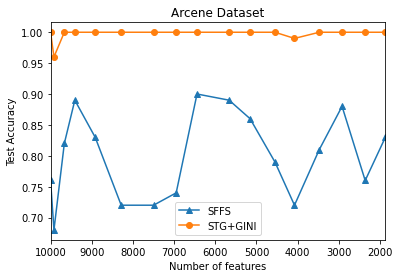

In [129]:
import matplotlib.pyplot as plt
x = results['STG_feats']
#plt.plot(results['STG_feats'], results['STG_acc'], label='STG', )
plt.plot(results['STG_feats'][3:], results['SFFS_acc'][3:], label='SFFS', marker='^')
# plt.plot(results['STG_feats'], results['DualSTG_acc'], label='DualSTG')
plt.plot(results['STG_feats'][3:], results['GINI_acc'][3:], label='STG+GINI', marker='o')
plt.xlim(max(x), min(x))
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Test Accuracy')
plt.title('Arcene Dataset')
plt.show()

In [130]:
results['STG_communication'] = 240

In [131]:
results.to_csv('results/CSVResults/arcene_results.csv')

In [132]:
results

,STG_acc,STG_feats,GINI_acc,GINI+STG_feats,DualSTG_feats,DualSTG_acc,Saved_communication,pred_emb,SFFS_acc,Epochs,STG_communication
0,0.86,10000,0.74,9037,9052,0.60,240,24,0.83,0,240
1,0.89,10000,1.00,6642,6884,0.93,240,24,0.78,10,240
2,1.00,10000,0.93,6226,6304,0.43,240,24,0.91,20,240
3,0.93,10000,1.00,5923,6011,0.85,240,24,0.76,30,240
4,1.00,9918,0.96,5739,5819,0.96,240,24,0.68,40,240
5,1.00,9666,1.00,5523,5614,0.88,240,24,0.82,50,240
6,1.00,9411,1.00,5441,5499,1.00,240,24,0.89,60,240
7,1.00,8917,1.00,5376,5363,1.00,240,24,0.83,70,240
8,1.00,8285,1.00,5226,5266,1.00,240,24,0.72,80,240
9,0.99,7499,1.00,5059,5164,1.00,240,24,0.72,90,240


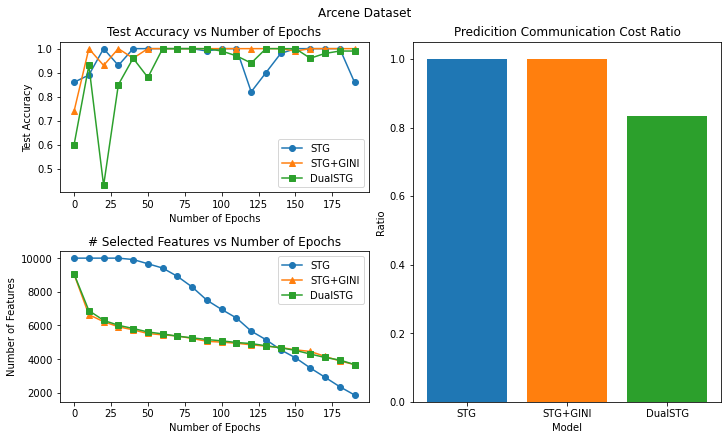

In [133]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              figsize=(10, 6), constrained_layout=True)
axd['upper left'].plot(np.arange(0, 200, 10), results['STG_acc'], label='STG', marker='o')
axd['upper left'].plot(np.arange(0, 200, 10), results['GINI_acc'], label='STG+GINI', marker='^')
axd['upper left'].plot(np.arange(0, 200, 10), results['DualSTG_acc'], label='DualSTG', marker='s')
axd['upper left'].legend()
axd['upper left'].set_xlabel('Number of Epochs')
axd['upper left'].set_ylabel('Test Accuracy')
axd['upper left'].set_title('Test Accuracy vs Number of Epochs')

axd['lower left'].plot(np.arange(0, 200, 10), results['STG_feats'], label='STG', marker='o')
axd['lower left'].plot(np.arange(0, 200, 10), results['GINI+STG_feats'], label='STG+GINI', marker='^')
axd['lower left'].plot(np.arange(0, 200, 10), results['DualSTG_feats'], label='DualSTG', marker='s')
axd['lower left'].set_xlabel('Number of Epochs')
axd['lower left'].set_ylabel('Number of Features')
axd['lower left'].set_title('# Selected Features vs Number of Epochs')
axd['lower left'].legend()


group_names = ['STG', 'STG+GINI', 'DualSTG']
values = [1, 1, results.tail(1)['pred_emb'].item()/24]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axd['right'].bar(group_names, values, align='center', color=colors)
axd['right'].set_xlabel('Model')
axd['right'].set_ylabel('Ratio')
axd['right'].set_title('Predicition Communication Cost Ratio')
fig.suptitle('Arcene Dataset')
plt.show()